In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Binarizer
from sklearn.ensemble import HistGradientBoostingClassifier

from feature_engine.imputation import AddMissingIndicator, MeanMedianImputer, CategoricalImputer
from feature_engine.encoding import RareLabelEncoder, OrdinalEncoder
from feature_engine.transformation import LogTransformer
from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper

import myPreprocessors as mypp #nuestra librerías de transformaciones.

import joblib

In [2]:
dataTrain = pd.read_csv("train.csv")
dataTrain.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
dataTrain = dataTrain.where(pd.notnull(dataTrain), None)

#### 1. Exploración de data 

In [4]:
dataTrain.shape

(891, 12)

In [5]:
dataTrain.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [6]:
dataTrain.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
dataTrain.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [8]:
dataTrain.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [9]:
dataTrain.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


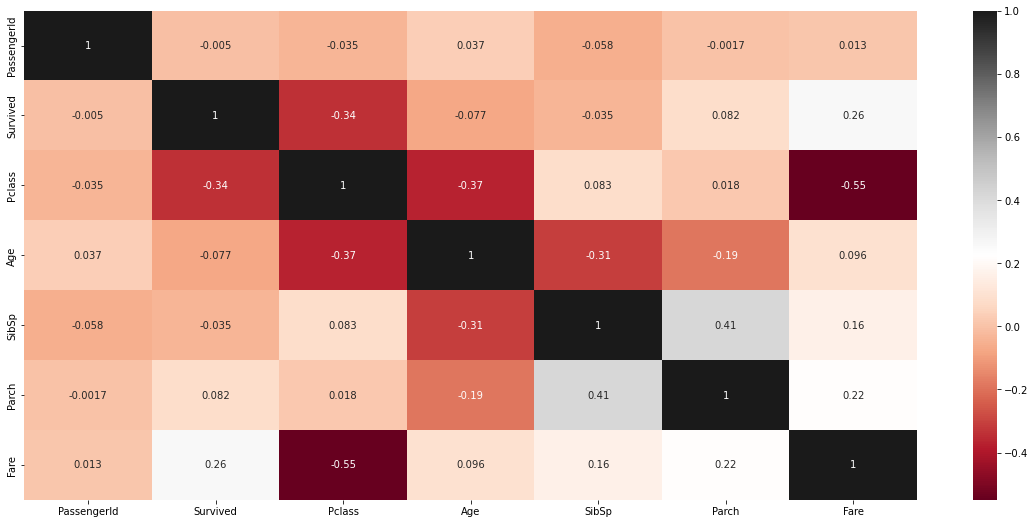

In [10]:
plt.subplots(figsize = (20,9))
sns.heatmap(dataTrain.corr(), annot=True,cmap="RdGy");

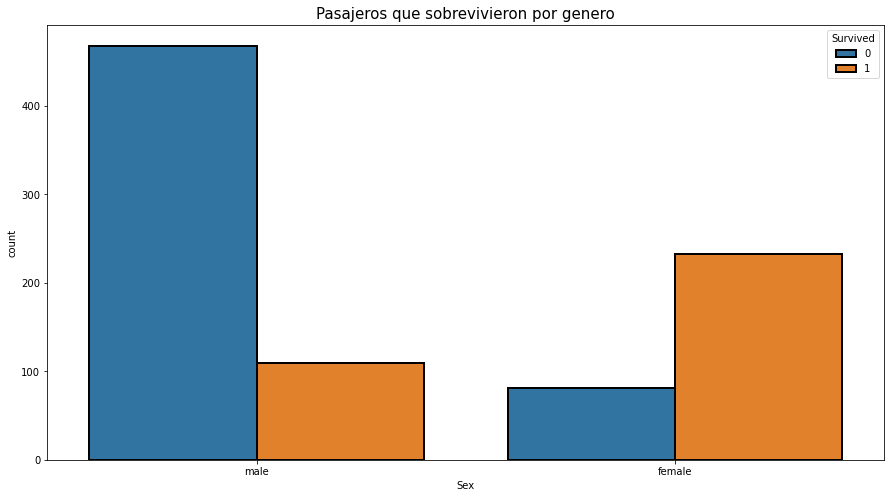

In [11]:
plt.subplots(figsize = (15,8))
ax=sns.countplot(x='Sex',data=dataTrain,hue='Survived',edgecolor=(0,0,0),linewidth=2)
dataTrain.shape
plt.title('Pasajeros que sobrevivieron por genero',fontsize=15)
labels = ['Mujer', 'Hombre']

([<matplotlib.axis.XTick at 0x1393d5ad400>,
 [Text(1, 0, 'First'), Text(2, 0, 'Second'), Text(3, 0, 'Third')])

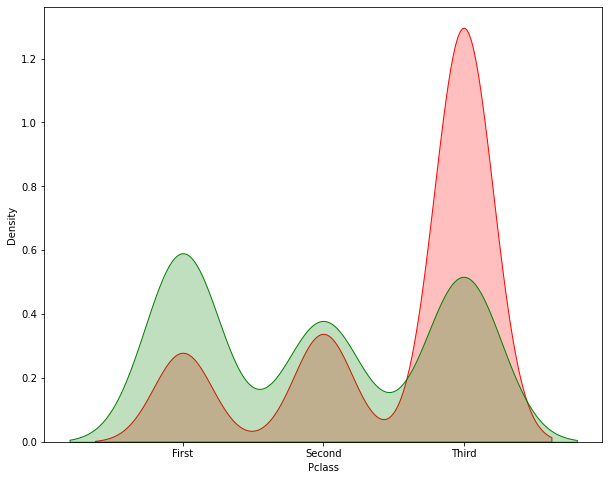

In [12]:
plt.subplots(figsize=(10,8))
sns.kdeplot(dataTrain.loc[(dataTrain['Survived'] == 0),'Pclass'],shade=True,color='red',label='Not Survived')
ax=sns.kdeplot(dataTrain.loc[(dataTrain['Survived'] == 1),'Pclass'],shade=True,color='green',label='Survived' )

labels = ['First', 'Second', 'Third']
plt.xticks(sorted(dataTrain.Pclass.unique()),labels)

#### 2. Train Test Split para Entrenamiento y Prueba

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    dataTrain.drop(['PassengerId','Survived'], axis=1),
    dataTrain['Survived'],
    test_size=0.3)

In [14]:
X_train

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
636,3,"Leinonen, Mr. Antti Gustaf",male,32.0,0,0,STON/O 2. 3101292,7.9250,None,S
293,3,"Haas, Miss. Aloisia",female,24.0,0,0,349236,8.8500,None,S
740,1,"Hawksford, Mr. Walter James",male,NaN,0,0,16988,30.0000,D45,S
530,2,"Quick, Miss. Phyllis May",female,2.0,1,1,26360,26.0000,None,S
16,3,"Rice, Master. Eugene",male,2.0,4,1,382652,29.1250,None,Q
...,...,...,...,...,...,...,...,...,...,...
38,3,"Vander Planke, Miss. Augusta Maria",female,18.0,2,0,345764,18.0000,None,S
660,1,"Frauenthal, Dr. Henry William",male,50.0,2,0,PC 17611,133.6500,None,S
846,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.5500,None,S
25,3,"Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...",female,38.0,1,5,347077,31.3875,None,S


#### 3. Configuración del Pipeline

In [15]:
#Imputación de variables numéricas
NUMERICAL_VARS_WITH_NA = ['Age']


#Variables que eliminaremos
DROP_FEATURES = ['Ticket','Cabin','Name']


#Variables para codificación ordinal.
QUAL_VARS = ['Sex', 'Embarked']


#Mapeo para varibels categótricas para calidad.
QUAL_MAPPINGS = {'male': 0, 'female': 1, 'C': 1,
                 'Q': 2, 'S': 3, 'NA': 0}


#Variables a utilizar en el entrenamiento
FEATURES = [
    'Pclass',
    'Sex', 
    'Age',
    'SibSp',
    'Parch',
    'Fare',
    'Embarked',
    ]

In [16]:
#X_train = X_train[FEATURES]

In [17]:
#y_train = np.log(y_train)
#y_test = np.log(y_test)

#### 4. Construcción del Pipeline

In [18]:
Titanic_pipeline_v122022 = Pipeline([
    # Drop de variables.
    ('drop_time_features',
        DropFeatures(features_to_drop=DROP_FEATURES)
    ),
    #=========== IMPUTACIONES ===============
         
    #Indicador faltane en variables numericas para imputación
    ('missing_indicator_numeric',
        AddMissingIndicator(variables=NUMERICAL_VARS_WITH_NA)
    ),
    
    #Imputación de variables numéricas
    ('mean_imputation',
        MeanMedianImputer(imputation_method='mean', variables=NUMERICAL_VARS_WITH_NA)
    ),
    
       
    
    #============= CODIFICACIÓN DE VARIABLES CATEGORICAS ORINALES ==================
    ('quality_mapper',
        mypp.Mapper(variables=QUAL_VARS, mappings=QUAL_MAPPINGS)
    ),
    
    
    #=============== SCALER ============
    ('scaler',
        MinMaxScaler()
    ),
    
    ('modelo_HistGradientBoostingClassifier', 
         HistGradientBoostingClassifier()
    )
])

In [19]:
#y_test = np.nan_to_num(y_test)

In [20]:
Titanic_pipeline_v122022.fit(X_train, y_train)

Pipeline(steps=[('drop_time_features',
                 DropFeatures(features_to_drop=['Ticket', 'Cabin', 'Name'])),
                ('missing_indicator_numeric',
                 AddMissingIndicator(variables=['Age'])),
                ('mean_imputation',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['Age'])),
                ('quality_mapper',
                 Mapper(mappings={'C': 1, 'NA': 0, 'Q': 2, 'S': 3, 'female': 1,
                                  'male': 0},
                        variables=['Sex', 'Embarked'])),
                ('scaler', MinMaxScaler()),
                ('modelo_HistGradientBoostingClassifier',
                 HistGradientBoostingClassifier())])

In [21]:
#X_test = X_test[FEATURES]

In [22]:
preds = Titanic_pipeline_v122022.predict(X_test)

In [23]:
rmseTest = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(preds)))
rmseTest

0.69623097109116

In [24]:
np.min(np.exp(y_train)), np.max(np.exp(y_train))

(1.0, 2.718281828459045)

In [25]:
rmseTest / (np.max(np.exp(y_train)) - np.min(np.exp(y_train)))

0.4051902077760665

In [26]:
#guardamos pipeline para uso en producción.
joblib.dump(Titanic_pipeline_v122022, 'titanic_v122022.pkl')

['titanic_v122022.pkl']

In [27]:
joblib.dump(FEATURES, 'FEATURES.pkl')

['FEATURES.pkl']